# Developping a Borrower Scoring Algorithm

Last updated : September 25th, 2022

## Introduction

During this project, I will use a dataset provided by a consumer finance companies to develop a machine learning algorithm that will predict if the borrower will have payment difficulties or not.

## 1. Data Loading and Filtering

First we will load the necessary packages and dataset and then we will carry on with the Cleaning and Analysis.

### 1.1 Loading our packages

We will import the necessary packages to run this project: matplotlib, numpy, pandas, seaborn.
Since I am running the project on Windows, I will also use sklearnex to increase the speed of sklearn.

In [2]:
#Importing packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
#Setting large figure size for Seaborn
sns.set(rc={'figure.figsize':(11.7,8.27),"font.size":20,"axes.titlesize":20,"axes.labelsize":18})

#Importing Intel extension for sklearn to improve speed
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


### 1.2 Loading the dataset

We will now load the dataset

In [3]:
# app_test = pd.read_csv("Data/application_test.csv", sep=",")
# app = pd.read_csv("Data/application_train.csv", sep=",")

# app.head()

## 2. Data Preparation

We will now clean our dataset.

### 2.1 Cleaning categorical variables

We will begin the cleaning process by cleaning categorical variables.

In [4]:
# Increasing maximum number of info rows 
pd.options.display.max_info_columns = 130


# #Looking at unique valeus of categorical variables
# def investigate_categories(df: pd.DataFrame):
#     for c in df.columns:
#         if df[c].dtype == 'object':
#             print("Column",c)
#             print("Unique values: {}".format(df[c].unique()))
#             print("")
#             print("-----------------------------------")
            
# investigate_categories(app)

In [5]:
# #Investigating "XNA" values in GENDER
# app[app["CODE_GENDER"] == 'XNA']
# #Only 4 rows

# #Let's look at the test data
# app_test[app_test["CODE_GENDER"] == 'XNA']
# #0 row

# #We will replace with the mode
# app["CODE_GENDER"] = app["CODE_GENDER"].fillna(app["CODE_GENDER"].mode())

In [6]:
# #Investigating "XNA" values in ORGANIZATION_TYPE
# app[app["ORGANIZATION_TYPE"] == 'XNA']
# #55374 rows

# app[app["ORGANIZATION_TYPE"] == 'XNA']["TARGET"].value_counts(normalize=True)
# #Significant deviation from the normal percentages, so it is interesting to keep these values

# #They will be encoded during the feature engineering part of the project

In [7]:
# #Looking at "nan" values in EMERGENCYSTATE_MODE
# print(len(app[app["EMERGENCYSTATE_MODE"].isna()]))

# app[app["EMERGENCYSTATE_MODE"].isna()]["TARGET"].value_counts(normalize=True)
# #Here it represents about half our dataset, we will create a "NA" variable as well since there is a small deviation from what
# #We would have expected

# app.loc[app["EMERGENCYSTATE_MODE"].isna(),"EMERGENCYSTATE_MODE"] = 'UKN'

In [8]:
# #Looking at "nan" values in OCCUPATION TYPE
# print(len(app[app["OCCUPATION_TYPE"].isna()]))

# app[app["OCCUPATION_TYPE"].isna()]["TARGET"].value_counts(normalize=True)
# #Here it represents about a third of our dataset, we will create a "NA" variable as well since there is a deviation from what
# #we would have expected

# app.loc[app["OCCUPATION_TYPE"].isna(),"OCCUPATION_TYPE"] = 'UKN'

In [9]:
# #Looking at "nan" values in NAME_TYPE_SUITE
# print(len(app[app["NAME_TYPE_SUITE"].isna()]))
# #Only 1292 NA values

# #We will replace these rows by the mode
# app["NAME_TYPE_SUITE"] = app["NAME_TYPE_SUITE"].fillna(app["NAMLE_TYPE_SUITE"].mode())

In [10]:
# #We can see that WEEKDAY_APPR_PROCESS_START is coded as a string

# import time
# #Let's convert it into week day number
# app["WEEKDAY_APPR_PROCESS_START"] = app["WEEKDAY_APPR_PROCESS_START"].apply(lambda x: time.strptime(x, '%A').tm_wday)

In [11]:
# #Verifying that we've dealt with all missing values of categorical variables
# for c in app.columns:
#     if app[c].dtype == 'object':
#         print(app[c].isna().sum().sum())

In [12]:
import time

#Summarizing preprocessing of categorical variables
def preprocess_cat_vars(df: pd.DataFrame):

    df["CODE_GENDER"] = df["CODE_GENDER"].fillna(df["CODE_GENDER"].mode())

    df.loc[df["EMERGENCYSTATE_MODE"].isna(),"EMERGENCYSTATE_MODE"] = 'UKN'

    df.loc[df["OCCUPATION_TYPE"].isna(),"OCCUPATION_TYPE"] = 'UKN'

    df["NAME_TYPE_SUITE"] = df["NAME_TYPE_SUITE"].fillna(df["NAME_TYPE_SUITE"].mode())

    #Let's convert it into week day number
    df["WEEKDAY_APPR_PROCESS_START"] = df["WEEKDAY_APPR_PROCESS_START"].apply(lambda x: time.strptime(x, '%A').tm_wday)
    
    #Replacing 0 values in categorical fields by nan
    for c in ["FONDKAPREMONT_MODE", "HOUSETYPE_MODE", "WALLSMATERIAL_MODE"]:
        df.loc[df[c] == 0, c] = np.nan
    
    return df
        

We have finished cleaning up categorical variables, now we will look at numeric variables 

### 2.2 Cleaning numeric variables 

In [13]:
#Looking for outliers 

#Increasing the number of maximum columns shown
pd.options.display.max_columns = 100
#app.describe()

In [14]:
# #DAYS_BIRTH, DAYS_REGISTRATION and DAYS_ID_PUBLISH only have negative values
# app["DAYS_REGISTRATION"] = abs(app["DAYS_REGISTRATION"])
# app["DAYS_ID_PUBLISH"] = abs(app["DAYS_ID_PUBLISH"])
# app["DAYS_BIRTH"] = abs(app["DAYS_BIRTH"])

# #DAYS EMPLOYED have abherrent values (365243 days, about 1000 years)
# app.loc[app["DAYS_EMPLOYED"] > 100000, "DAYS_EMPLOYED"] = np.nan
# app["DAYS_EMPLOYED"] = abs(app["DAYS_EMPLOYED"])

# print(app["DAYS_BIRTH"].min()/365, app["DAYS_BIRTH"].max()/365)
# #No outlier data, from 20 to 69 years

# def label_age(days_birth):
#     age_years = days_birth / 365
#     if age_years < 30: return 1
#     elif age_years < 40: return 2
#     elif age_years < 50: return 3
#     elif age_years < 60: return 4
#     elif age_years < 70: return 5
#     else: return 0
    
# app["AGE_LABEL"] = app["DAYS_BIRTH"].apply(lambda x: label_age(x))

# app = app[app['AMT_INCOME_TOTAL'] < 20000000] # remove an outlier (117 million)

# # Calculated features
# app['DAYS_EMPLOYED_PCT'] = app['DAYS_EMPLOYED'] / app['DAYS_BIRTH']
# app['INCOME_CREDIT_PCT'] = app['AMT_INCOME_TOTAL'] / app['AMT_CREDIT']
# app['INCOME_PER_PERSON'] = app['AMT_INCOME_TOTAL'] / app['CNT_FAM_MEMBERS']
# app['ANNUITY_INCOME_PCT'] = app['AMT_ANNUITY'] / app['AMT_INCOME_TOTAL']
# app['PAYMENT_RATE'] = app['AMT_ANNUITY'] / app['AMT_CREDIT']

In [15]:
# app.describe()

In [16]:
# #Turning SK_ID_CURR into an ID field :
# app.set_index('SK_ID_CURR', inplace=True)

# app.head()

Analysis of the describe() output shows that there is **no clear outlier** in the rest of the numeric data. We can now start handling missing values.

In [17]:
# len(app.columns[app.isnull().any()])
# #21 columns with NA values

# #Dropping rows with more than 50% na values
# def drop_na_rows(df: pd.DataFrame, pct: float):
#     n = len(df.columns)
#     cutoff = n*pct/100 
#     df = df[df.isna().sum(axis=1) > cutoff]

# drop_na_rows(app, 50)
#No row was removed


In [18]:
#Summarizing cleaning of numeric variables:

def preprocess_num_vars(df: pd.DataFrame,
                        quantiles=[25650.0,81000.0,99000.0,112500.0,135000.0,147150.0,162000.0,180000.0,225000.0,270000.0,117000000.0]):
    #Setting index
    data = df.copy()
    data.set_index('SK_ID_CURR', inplace=True)
    
    #DAYS_BIRTH, DAYS_REGISTRATION and DAYS_ID_PUBLISH only have negative values
    data["DAYS_REGISTRATION"] = abs(data["DAYS_REGISTRATION"])
    data["DAYS_ID_PUBLISH"] = abs(data["DAYS_ID_PUBLISH"])
    data["DAYS_BIRTH"] = abs(data["DAYS_BIRTH"])

    #DAYS EMPLOYED have abherrent values (365243 days, about 1000 years)
    data["DAYS_EMPLOYED_ANOM_FLAG"] = 0 #Creating anomaly flag
    data.loc[data["DAYS_EMPLOYED"] > 100000, "DAYS_EMPLOYED_ANOM_FLAG"] = 1 
    data.loc[data["DAYS_EMPLOYED"] > 100000, "DAYS_EMPLOYED"] = np.nan
    data["DAYS_EMPLOYED"] = abs(data["DAYS_EMPLOYED"])

    def label_age(days_birth):
        age_years = days_birth / 365
        if age_years < 30: return 1
        elif age_years < 40: return 2
        elif age_years < 50: return 3
        elif age_years < 60: return 4
        elif age_years < 70: return 5
        else: return 0

    data["AGE_LABEL"] = data["DAYS_BIRTH"].apply(lambda x: label_age(x))

    data = data[data['AMT_INCOME_TOTAL'] < 20000000] # remove an outlier (117 million)

    
    data["AMT_INCOME_BIN"] = pd.cut(data["AMT_INCOME_TOTAL"], bins=quantiles, labels=False)

    # Calculated features
    data['DAYS_EMPLOYED_PCT'] = data['DAYS_EMPLOYED'] / data['DAYS_BIRTH']
    data['INCOME_CREDIT_PCT'] = data['AMT_INCOME_TOTAL'] / data['AMT_CREDIT']
    data['INCOME_PER_PERSON'] = data['AMT_INCOME_TOTAL'] / data['CNT_FAM_MEMBERS']
    data['ANNUITY_INCOME_PCT'] = data['AMT_ANNUITY'] / data['AMT_INCOME_TOTAL']
    data['PAYMENT_RATE'] = data['AMT_ANNUITY'] / data['AMT_CREDIT']
    
    return data


We have verified that all of our 3 sets are composed only of numeric features and that they have the same number of columns.

We will now use **additional features from other dataframes** to increase the performance of our models.

### 2.3 Using previous application data

In [19]:
# prev_app = pd.read_csv("Data/previous_application.csv", sep=",")

# prev_app.info()

In [20]:
# prev_app.describe()

In [21]:
# #We are interested in DAYS_LAST_DUE (the number of days the borrower has to pay previous applications)
# #But there are illogical values (365243 which is equal to 1000 years)
# #First we'll replace all the values by nan
# prev_app.loc[prev_app.DAYS_LAST_DUE > 300000, "DAYS_LAST_DUE"] = np.nan
# prev_app.loc[prev_app.DAYS_FIRST_DUE > 300000, "DAYS_FIRST_DUE"] = np.nan
# prev_app.loc[prev_app.DAYS_LAST_DUE_1ST_VERSION > 300000, "DAYS_LAST_DUE_1ST_VERSION"] = np.nan
# prev_app.loc[prev_app.DAYS_FIRST_DRAWING > 300000, "DAYS_FIRST_DRAWING"] = np.nan
# prev_app.loc[prev_app.DAYS_TERMINATION > 300000, "DAYS_TERMINATION"] = np.nan

# #Defining current amount due, we have to add a negative sign because DAYS_LAST_DUE is negative
# prev_app["AMT_CURR_DUE"] = -prev_app["AMT_ANNUITY"]*prev_app["DAYS_LAST_DUE"]/365

# prev_app["CURR_ANNUITY"] = 0
# prev_app.loc[prev_app["DAYS_LAST_DUE"] < 0, "CURR_ANNUITY"] = prev_app["AMT_ANNUITY"]

# # Calculated variables
# prev_app['APPLICATION_CREDIT_DIF'] = prev_app['AMT_APPLICATION'] - prev_app['AMT_CREDIT']
# prev_app['CREDIT_TO_ANNUITY'] = prev_app['AMT_CREDIT'] / prev_app['AMT_ANNUITY']
# prev_app['DOWN_PAYMENT_TO_CREDIT'] = prev_app['AMT_DOWN_PAYMENT'] / prev_app['AMT_CREDIT']

# prev_app.head()

In [22]:
# #Verifying unique values of contract status
# prev_app.NAME_CONTRACT_STATUS.unique()
# #4 categories, Approved, Refused, Canceled and Unused offer

# prev_app["AMT_GRANTED"] = 0
# prev_app.loc[prev_app["NAME_CONTRACT_STATUS"] == "Approved", "AMT_GRANTED"] = prev_app["AMT_CREDIT"]

# prev_app.head()

In [23]:
# aggregations = {
#         'AMT_ANNUITY': ['std', 'mean', 'sum'],
#         'AMT_APPLICATION': ['std', 'mean', 'sum'],
#         'AMT_CREDIT': ['std', 'mean', 'sum'],
#         'AMT_CURR_DUE': ['std', 'mean', 'sum'],
#         'CURR_ANNUITY': ['std', 'mean', 'sum'],
#         'AMT_DOWN_PAYMENT': ['std', 'mean', 'sum'],
#         'AMT_GOODS_PRICE': ['std', 'mean', 'sum'],
#         'HOUR_APPR_PROCESS_START': ['std', 'mean'],
#         'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
#         'DAYS_DECISION': ['std', 'mean', 'sum'],
#         'CNT_PAYMENT': ['mean', 'sum','std'],
#         'SK_ID_PREV': ['nunique'],
#         'DAYS_TERMINATION': ['mean', 'sum', 'std'],
#         'DOWN_PAYMENT_TO_CREDIT': ['sum', 'mean', 'std']
#     }

# #We will aggregate by SK_ID_CURR and retrieve important information about previous applications :
# prev_app_numbers = prev_app.groupby("SK_ID_CURR").agg(aggregations)

# #Renaming columns to remove multi indexing
# prev_app_numbers.columns = pd.Index(['APP' + '_' + e[0] + '_' + e[1] for e in prev_app_numbers.columns])

# prev_app_numbers.head()

In [24]:
# #Creating a dataframe with the number of each different name contract status by SK_ID_CURR
# prev_app_status = pd.crosstab(prev_app['SK_ID_CURR'], prev_app['NAME_CONTRACT_STATUS'])

# cols = ["N_PREV_APPROVED","N_PREV_CANCELED","N_PREV_REFUSED","N_PREV_UNUSED"]
# prev_app_status.columns = cols

# #Importing the number of unique applications from prev_app_numbers
# prev_app_status = pd.merge(prev_app_status, prev_app_numbers[["APP_SK_ID_PREV_nunique"]],
#                            how="inner", left_index=True, right_index=True)

# for c in cols:
#     prev_app_status[c] = prev_app_status[c] / prev_app_status["APP_SK_ID_PREV_nunique"]

# prev_app_status = prev_app_status.drop(columns={"APP_SK_ID_PREV_nunique"})
# prev_app_status.head()

In [25]:
# prev_app_df = pd.merge(prev_app_numbers, prev_app_status, how='inner', left_index=True, right_index=True)

# prev_app_df.head()

In [26]:
# #Saving prev_app_df to prevent RAM usage and reduce rerun time
# prev_app_df.to_csv("Data/prev_app_df.csv")

In [27]:
def load_prev_app_info(X_train, test_set=False, X_test=None, X_val=None, validation_set=False):

    #Joining this new data and filling NAs with 0 (since it means there was no previous application)
    X_train = pd.merge(X_train, prev_app_df, how='left', left_index=True, right_index=True)
    if not test_set:
        return X_train
    else:
        X_test = pd.merge(X_test, prev_app_df, how='left', left_index=True, right_index=True)
    if validation_set:
        X_val = pd.merge(X_val, prev_app_df, how='left', left_index=True, right_index=True)
        return X_train, X_test, X_val
    return X_train, X_test


### 2.4 Using Credit Bureau information

We also have information about CB for each borrower that we can use to increase the accuracy of our model:

In [28]:
# bureau = pd.read_csv("Data/bureau.csv", sep=",")

# bureau.info()

In [29]:
# bureau.describe()

In [30]:
#print(bureau.CREDIT_ACTIVE.unique())
# print(bureau.CREDIT_CURRENCY.unique())

# len(bureau[bureau.CREDIT_CURRENCY.isna()])
# #Credit active is interesting because of the bad debt field
# #Currency is also interesting because it could be an indicator to fraudulent transactions

In [31]:
# #Calculating new features

# #Date differences
# bureau['CREDIT_DURATION'] = -bureau['DAYS_CREDIT'] + bureau['DAYS_CREDIT_ENDDATE']
# bureau['ENDDATE_DIF'] = bureau['DAYS_CREDIT_ENDDATE'] - bureau['DAYS_ENDDATE_FACT']

# #Day overdue flags:
# bureau['BUREAU_IS_DPD'] = bureau['CREDIT_DAY_OVERDUE'].apply(lambda x: 1 if x > 0 else 0)
# bureau['BUREAU_IS_DPD_OVER100'] = bureau['CREDIT_DAY_OVERDUE'].apply(lambda x: 1 if x > 100 else 0)
                                                                     
# #Debt ratio                                                         
# bureau['BUREAU_CREDIT_DEBT_RATIO'] = bureau['AMT_CREDIT_SUM_DEBT'] / bureau['AMT_CREDIT_SUM']


# #We will now aggreagte over SK_ID_CURR to calculate relevant numeric features 

# aggregations = {
#         'DAYS_CREDIT': ['sum', 'mean', 'std'],
#         'DAYS_CREDIT_ENDDATE': ['sum', 'mean', 'std'],
#         'CREDIT_DAY_OVERDUE': ['min', 'max', 'sum','mean', 'std'],
#         'AMT_CREDIT_MAX_OVERDUE': ['min', 'max', 'sum', 'mean', 'std'],
#         'AMT_CREDIT_SUM': ['min', 'max', 'sum', 'mean', 'std'],
#         'AMT_CREDIT_SUM_DEBT': ['min', 'max', 'sum', 'mean', 'std'],
#         'AMT_CREDIT_SUM_OVERDUE': ['min', 'max', 'sum', 'mean', 'std'],
#         'AMT_CREDIT_SUM_LIMIT': ['min', 'max', 'sum', 'mean', 'std'],
#         'AMT_ANNUITY': ['min', 'max', 'mean', 'sum', 'std'],
#         'CNT_CREDIT_PROLONG': ['sum', 'mean', 'std'],
#         'SK_ID_BUREAU': ['count'],
#         'DAYS_ENDDATE_FACT': ['min', 'max', 'mean', 'std'],
#         'ENDDATE_DIF': ['min', 'max', 'mean', 'std'],
#         'BUREAU_CREDIT_DEBT_RATIO': ['min', 'max', 'mean','std'],
#         'BUREAU_IS_DPD': ['mean', 'sum', 'std'],
#         'BUREAU_IS_DPD_OVER100': ['mean', 'sum', 'std']
# } 
                                                                     
# bureau_num = bureau.groupby("SK_ID_CURR").agg(aggregations)

# #Renaming columns to remove multi indexing
# bureau_num.columns = pd.Index(['BUREAU' + '_' + e[0] + '_' + e[1] for e in bureau_num.columns])

# bureau_num.head()

In [32]:
# #We will count the number of CB credits with each of these attributes :
# bureau_categ1 = pd.crosstab(bureau['SK_ID_CURR'], bureau['CREDIT_ACTIVE'])
# bureau_categ2 = pd.crosstab(bureau['SK_ID_CURR'], bureau['CREDIT_CURRENCY'])

# bureau_categ = pd.merge(bureau_categ1, bureau_categ2, how="outer", left_index=True, right_index=True)

# cols = ['CB_ACTIVE', 'CB_BAD_DEBT', 'CB_CLOSED', 'CB_SOLD',
#                         'CB_CURR1', 'CB_CURR2', 'CB_CURR3', 'CB_CURR4']
# bureau_categ.columns = cols

# bureau_categ = pd.merge(bureau_categ, bureau_num[["BUREAU_SK_ID_BUREAU_count"]], how="inner", left_index=True, right_index=True)

# for c in cols:
#     bureau_categ[c] = bureau_categ[c] / bureau_categ["BUREAU_SK_ID_BUREAU_count"]
# bureau_categ.head()

In [33]:
# #We now load the bureau_balance csv file
# bureau_balance = pd.read_csv("Data/bureau_balance.csv", sep=',')

# bureau_balance.STATUS.value_counts(normalize=True)

# bureau_balance.head()

In [34]:
# #We create a crosstab to count the number of status type for each sk_id_bureau
# bureau_balance_stats = pd.crosstab(bureau_balance['SK_ID_BUREAU'], bureau_balance['STATUS'])

# bureau_balance_stats.head()

In [35]:
# #Counting the number of columns for each sk_id_bureau
# bureau_balance_count = bureau_balance[["SK_ID_BUREAU","MONTHS_BALANCE"]].groupby("SK_ID_BUREAU").count()

# bureau_balance_count.columns = ["CB_COUNT"]

# #Renaming the columns for better clarity
# cols = ["CB_DPD_0","CB_DPD_1","CB_DPD_2","CB_DPD_3","CB_DPD_4","CB_DPD_5","CB_BAL_CLOSED","CB_BAL_UKN"]
# bureau_balance_stats.columns=["CB_DPD_0","CB_DPD_1","CB_DPD_2","CB_DPD_3","CB_DPD_4","CB_DPD_5","CB_BAL_CLOSED","CB_BAL_UKN"]

# bureau_balance_stats = pd.merge(bureau_balance_stats, bureau_balance_count, how="inner", left_index=True, right_index=True)

# for c in cols:
#     bureau_balance_stats[c] = bureau_balance_stats[c] / bureau_balance_stats["CB_COUNT"]

# bureau_balance_stats.head()

In [36]:
# #Joining with the main CB dataframe to retrieve SK_ID_CURR info
# bureau_num_bal = pd.merge(bureau_balance_stats, bureau[["SK_ID_BUREAU","SK_ID_CURR"]], how='inner', left_index=True, right_on='SK_ID_BUREAU')

# #Creating aggregator
# agg_functions = ['min', 'max', 'mean', 'std', 'sum']

# aggregations = {
#     c: agg_functions for c in bureau_balance_stats.columns
# }

# #Aggregating by SK_ID_CURR
# bureau_num_bal = bureau_num_bal.groupby("SK_ID_CURR").agg(aggregations)

# #Renaming columns to remove multi indexing
# bureau_num_bal.columns = pd.Index(['BB' + '_' + e[0] + '_' + e[1] for e in bureau_num_bal.columns])

# bureau_num_bal.head()

In [37]:
# bureau_num_bal.info()
# #We only have 134k different SK_ID, which is about 40% of our dataset. 
# #We will fill nulls with 0 because it means that the other SK_ID were not referenced at the Credit Bureau

In [38]:
# bureau_num_full = pd.merge(bureau_num, bureau_num_bal, how='outer', left_index=True, right_index=True)

# bureau_num_full.info()
# bureau_num_full.head()

In [39]:
# #Merging the 2 dataframes with bureau information
# bureau_df = pd.merge(bureau_categ, bureau_num_full, how='outer', left_index=True, right_index=True)

# bureau_df.replace([np.inf, -np.inf], np.nan, inplace=True) #Removing infinite values

# bureau_df.head()

In [40]:
# #Saving bureau_df to reduce RAM usage
# bureau_df.to_csv("Data/bureau_df.csv")

In [41]:
def load_bureau_info(X_train, test_set=False, X_test=None, X_val=None, validation_set=False):

    bureau_df.set_index("SK_ID_CURR", inplace=True)
    #Joining this new data
    X_train = pd.merge(X_train, bureau_df, how='left', left_index=True, right_index=True)
    if not test_set:
        return X_train
    else:
        X_test = pd.merge(X_test, bureau_df, how='left', left_index=True, right_index=True)
    if validation_set:
        X_val = pd.merge(X_val, bureau_df, how='left', left_index=True, right_index=True)
        return X_train, X_test, X_val
    return X_train, X_test

### 2.5 Using Cash balance information

In [42]:
# cash = pd.read_csv("Data/POS_CASH_balance.csv", sep=',')

# cash.head()

In [43]:
# #Creating late payment flag
# cash['LATE_PAYMENT'] = cash['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)
# cash['POS_IS_DPD_OVER_100'] = cash['SK_DPD'].apply(lambda x: 1 if x >= 100 else 0)

# #Creating aggregator
# agg_functions = ['min', 'max', 'mean', 'std', 'sum']

# #Aggregating on all columns except months_balance and sk_id_prev
# aggregations = {
#     c: agg_functions for c in cash.drop(columns={"SK_ID_CURR","SK_ID_PREV","MONTHS_BALANCE", "NAME_CONTRACT_STATUS"}).columns
# }

# #Adding a nunique count on SK_ID_PREV
# aggregations["SK_ID_PREV"] = "nunique"

# #Aggregating over "SK_ID_CURR"
# cash_df = cash.groupby("SK_ID_CURR").agg(aggregations)

# #Renaming columns to remove multi indexing
# cash_df.columns = pd.Index(['CASH' + '_' + e[0] + '_' + e[1] for e in cash_df.columns])

# cash_df.replace([np.inf, -np.inf], np.nan, inplace=True) #Removing infinite values
# cash_df.head()

In [44]:
# #Saving cash_df to csv to save RAM usage
# cash_df.to_csv("Data/cash_df.csv")

In [45]:
def load_cash_info(X_train, test_set=False, X_test=None, X_val=None, validation_set=False):

    cash_df.set_index("SK_ID_CURR", inplace=True)

    #Joining this new data
    X_train = pd.merge(X_train, cash_df, how='left', left_index=True, right_index=True)
    if not test_set:
        return X_train
    else:
        X_test = pd.merge(X_test, cash_df, how='left', left_index=True, right_index=True)
    if validation_set:
        X_val = pd.merge(X_val, cash_df, how='left', left_index=True, right_index=True)
        return X_train, X_test, X_val
    return X_train, X_test

### 2.6 Using CC Balance information

In [46]:
# cc = pd.read_csv("Data/credit_card_balance.csv",sep=",")

# cc.head()

In [47]:
# #Calculating new features
# cc['LATE_PAYMENT'] = cc['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)
# cc['CARD_IS_DPD_OVER_100'] = cc['SK_DPD'].apply(lambda x: 1 if x >= 100 else 0)

# #Creating aggregator
# agg_functions = ['min', 'max', 'mean', 'std', 'sum']

# #Aggregating on all columns except months_balance and sk_id_prev
# aggregations = {
#     c: agg_functions for c in cc.drop(columns={"SK_ID_CURR","SK_ID_PREV","MONTHS_BALANCE", "NAME_CONTRACT_STATUS"}).columns
# }

# #Adding a nunique count on SK_ID_PREV
# aggregations["SK_ID_PREV"] = "nunique"

# #Aggregating over "SK_ID_CURR"
# cc_df = cc.groupby("SK_ID_CURR").agg(aggregations)

# #Renaming columns to remove multi indexing
# cc_df.columns = pd.Index(['CC_BAL' + '_' + e[0] + '_' + e[1] for e in cc_df.columns])

# cc_df.replace([np.inf, -np.inf], np.nan, inplace=True) #Removing infinite values

# cc_df.head()

# # #Investigating possible months balance values
# # cc.MONTHS_BALANCE.value_counts()

In [48]:
# #Saving cc_df to prevent high RAM usage
# cc_df.to_csv("Data/cc_df.csv")

In [49]:
def load_cc_info(X_train, test_set=False, X_test=None, X_val=None, validation_set=False):

    cc_df.set_index("SK_ID_CURR", inplace=True)

    #Joining this new data
    X_train = pd.merge(X_train, cc_df, how='left', left_index=True, right_index=True)
    if not test_set:
        return X_train
    else:
        X_test = pd.merge(X_test, cc_df, how='left', left_index=True, right_index=True)
    if validation_set:
        X_val = pd.merge(X_val, cc_df, how='left', left_index=True, right_index=True)
        return X_train, X_test, X_val
    return X_train, X_test

### 2.7 Using installment payments information

In [50]:
# install = pd.read_csv("Data/installments_payments.csv",sep=",")

# install.head()

In [51]:
# #Converting the DAYS columns into positive values
# install["DAYS_INSTALMENT"] = install["DAYS_INSTALMENT"].apply(lambda x: abs(x))
# install["DAYS_ENTRY_PAYMENT"] = install["DAYS_ENTRY_PAYMENT"].apply(lambda x: abs(x))

# #Calculating simple differences
# install["DAYS_DELAY"] = install["DAYS_ENTRY_PAYMENT"] - install["DAYS_INSTALMENT"]
# install['PAID_OVER_AMOUNT'] = install['AMT_PAYMENT'] - install['AMT_INSTALMENT']

# #PAID_OVER flag
# install['PAID_OVER'] = install['PAID_OVER_AMOUNT'].apply(lambda x: 1 if x > 0 else 0)

# #Difference between DPD and Days before due
# install['DPD_diff'] = install['DAYS_ENTRY_PAYMENT'] - install['DAYS_INSTALMENT']
# install['DBD_diff'] = install['DAYS_INSTALMENT'] - install['DAYS_ENTRY_PAYMENT']

# #Late payment ratio
# install['LATE_PAYMENT'] = install.apply(lambda x: 1 if x['DPD_diff'] > 0 else 0, axis=1)
# install['INSTALMENT_PAYMENT_RATIO'] = install['AMT_PAYMENT'] / install['AMT_INSTALMENT']
# install['LATE_PAYMENT_RATIO'] = install.apply(lambda x: x['INSTALMENT_PAYMENT_RATIO'] if x['LATE_PAYMENT'] == 1 else 0, axis=1)

# #Over 100 flag
# install['INS_IS_DPD_OVER_100'] = install['DPD_diff'].apply(lambda x: 1 if (x >= 100) else 0)

# #We have both high negative and positive delay values which indicate early or very late payment
# #We will now calculate the difference in percentage between AMT_INSTALMENT and AMT_PAYMENT
# install["DEFICIT_PCT"] = (install["AMT_INSTALMENT"] - install["AMT_PAYMENT"])*100/install["AMT_INSTALMENT"]

# install.head()

In [52]:
# #Creating aggregator
# agg_functions = ['min', 'max', 'mean', 'std', 'sum']

# #Aggregating on all columns except sk_id_prev
# aggregations = {
#     c: agg_functions for c in install.drop(columns={"SK_ID_PREV","SK_ID_CURR"}).columns
# }

# #Adding a nunique count on SK_ID_PREV
# aggregations["SK_ID_PREV"] = "nunique"

# #Aggregating over "SK_ID_CURR"
# install_df = install.groupby("SK_ID_CURR").agg(aggregations)

# #Renaming columns to remove multi indexing
# install_df.columns = pd.Index(['CC' + '_' + e[0] + '_' + e[1] for e in install_df.columns])


# install_df.head()

In [53]:
# # Saving install_df to a csv to prevent repetitive rerun of the program
# install_df.to_csv("Data/install_df.csv")

In [54]:
def load_install_info(X_train, test_set=False, X_test=None, X_val=None, validation_set=False):

    install_df.set_index("SK_ID_CURR", inplace=True)
    install_df.replace([np.inf, -np.inf], np.nan, inplace=True) #Removing infinite values

    #Joining this new data and filling NAs with 0
    X_train = pd.merge(X_train, install_df, how='left', left_index=True, right_index=True)
    
    if not test_set:
        return X_train
    else:
        X_test = pd.merge(X_test, install_df, how='left', left_index=True, right_index=True)
    
    if validation_set:
        X_val = pd.merge(X_val, install_df, how='left', left_index=True, right_index=True)
        return X_train, X_test, X_val
    
    return X_train, X_test

## 3. Exploratory Data Analysis

We will now analyse our dataset.

### 3.1 Structure analysis

In [55]:
# print(df.shape)
# print(pd.value_counts(df.dtypes))
# df.select_dtypes(exclude='number').head()

In [56]:
# #Replacing 0 values in categorical fields by nan
# for c in ["FONDKAPREMONT_MODE", "HOUSETYPE_MODE", "WALLSMATERIAL_MODE"]:
#     df.loc[df[c] == 0, c] = np.nan
    
# # Check number of duplicates
# n_duplicates = df.duplicated().sum()
# print("Number of duplicates:",n_duplicates)

### 3.2 Missing values

We will now explore missing values, but data imputation will be performed in a later step after train/test/val split.

In [57]:
# percent_missing = df.isnull().sum() * 100 / len(df)

# missing_value_df = pd.DataFrame({'percent_missing': percent_missing})

# missing_value_df.sort_values('percent_missing', ascending=False, inplace=True)

# print(len(missing_value_df[missing_value_df.percent_missing > 50])) #201 columns with more than 50% NA

# missing_value_df.head(20)

In [58]:
# #Plotting missing columns
# plt.figure(figsize=(10, 8))
# plt.imshow(df.isna(), aspect="auto", interpolation="nearest", cmap="gray")
# plt.xlabel("Column Number")
# plt.ylabel("Sample Number");

We can see that for some columns (number ~ 120-150) there is no data for all samples above ~205000

Let's look at a representation of missing features: 

In [59]:
# plt.hist(missing_value_df, bins = range(0,110,10))
# plt.xlabel("Percentage of features missing")
# plt.ylabel("Number of columns")
# plt.title("Percentage of features missing per number of column")
# plt.show()

In [60]:
#Dropping columns with more than x% na values
def drop_na_columns(df: pd.DataFrame, percent: float):
    n = len(df)
    cutoff = n*percent/100
    for c in df.columns:
        if len(df[c].dropna()) < cutoff:
            df.drop(columns={c}, inplace=True)

# app.info()

In [61]:
# #We can see that there is a lot of columns with more than 70% na values and we will delete them from our database.
# print(df.shape)
# drop_na_columns(df, 30)
# print(df.shape)
# #This removed 155 features!

### 3.3 General Distribution

In [62]:
# #Generate the number of continuous columns
# cols_continuous = df.select_dtypes(include="number").nunique() >= 100

# df_continuous = df[cols_continuous[cols_continuous].index]

# print(df_continuous.shape)

# #sns.pairplot(df_continuous);
# #Too many continuous variables to plot pairplot

In [63]:
# #Plotting a histogram of continuous variables
# from functions import *
# df_continuous.histPlotAll()

### 3.4 Feature correlation

We can now investigate the correlation between our features.
Since we have too many features, it is impossible to display a heatmap but we will look at the features with the most correlation.

#### 3.4.1 Correlation with target variable

In [64]:
# df_corr = df.corr()

# df_corr.head()

In [65]:
# target_corr = pd.DataFrame(df_corr.TARGET)

# #Turning correlation coefficients into absolute values
# target_corr["TARGET"] = abs(target_corr["TARGET"])
# target_corr.loc[target_corr["TARGET"] == 1, "TARGET"] = 0

# target_corr = target_corr.sort_values(by="TARGET", ascending=False)
# target_corr.head(10).plot(kind='bar', legend=None)
# plt.xlabel("Feature")
# plt.ylabel("Correlation (abs) with TARGET")
# plt.title("Top 10 features most correlated with TARGET")
# plt.show()

We can see that EXT_SOURCE 1, 2 and 3 are the features most correlated with TARGET.

#### 3.4.2 Inter Feature Correlation

In [66]:
# #Create a mask to remove the diagonal and the upper triangle.
# lower_triangle_mask = np.tril(np.ones(df_corr.shape), k=-1).astype("bool")

# #Stack all correlations, after applying the mask
# df_corr_stacked = df_corr.where(lower_triangle_mask).stack().sort_values()

# # Showing the lowest and highest correlations in the correlation matrix
# df_corr = abs(df_corr)
# sns.heatmap(df_corr)
# plt.show()

We can see that several features are correlated. There are 3 particularly interesting areas of interest in this plot :
    
- CASH AND CC CORRELATED variables (bottom right)
- Correlation between the aggregates of base variables (top left)
- APP correlated variables (middle)

Since these correlation will negatively impact our model, we will have to remove them from our database.

## 3. Feature Engineering

We've now finished cleaning incorrect values. 
Before starting to perform data imputation, we need to perform a **train/validation/test split**. This will **prevent us from introducing data leakage during the cleaning process**. 

### 3.1 Performing train / test / validation split

We will divide our dataset as such : 

-  80% train set 
-  10% validation 
-  10% test

We will be able to revisit this values during the hyperparameter tuning part of the project.

In [93]:
from sklearn.model_selection import train_test_split

def perform_split(X, y , ID, target_col: str, validation_set: bool, shuffle: bool, random_state: int, test_size: float):

    #Splitting train and test sets, we have to add indices to conserve the original index
    X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(
        X, y, ID, test_size=test_size, stratify=y, shuffle=shuffle, random_state=random_state)

    #Assigning the correct indices (the SK_IDs) to y_test
    y_test.index = indices_test
    
    if validation_set:
        #Applying the same function to separate train and validation set
        X_train, X_val, y_train, y_val, indices_train, indices_val = train_test_split(
            X_train, y_train, indices_train, test_size = test_size/(1-test_size), 
            shuffle=shuffle, random_state=random_state)

        #Assigning the SK IDs to y_train and y_val
        y_val.index = indices_val
        y_train.index = indices_train
        return X_train, y_train, X_test, y_test, X_val, y_val
    
    y_train.index = indices_train
    return X_train, y_train, X_test, y_test


In [68]:
# print(len(X_train), len(X_test), len(X_val))
#Our test and validation set have the same length and its 10% of the overall length of X

Now that we have performed the split, we can carry on to perform data imputation.

These operations will also have to be performed on the test and train_set, so we will create a function that we will be able to apply to the 3 sets.

### 3.2 Data Imputation

First we will investigate what columns still have missing values. 
Normally, we have replaced all missing features for categorical variables.

In [69]:
# #For ease of use, we will rename X_train to df so we can better replicate our code afterwards
# df = X_train.copy()

# def check_col_nas_type(df: pd.DataFrame):
#     type_cols = []
#     #Verifying the type of columns with missing values
#     for c in df.columns[df.isna().any()].tolist():
#         if ~np.isin(df[c].dtype, type_cols):
#             type_cols.append(df[c].dtype)
#     return(type_cols)

# check_col_nas_type(df)
# #This verifies that we only need to perform data imputation on numeric features

In [70]:
# #Loading visualization functions present in the functions.py file
# from functions import *

# #Visualizing distribution of all numeric variables
# histPlotAll(df)

# #Apart from HOUR_APPR_PROCESS_START, all numeric variables seem to be not normally distributed

In [71]:
from scipy import stats
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

#Defining a data imputation function, we will use the NAME_CONTRACT_TYPE as a category_column

#This data_imputation script can be improved during the hyperparameter setting phase

def data_imputation(df: pd.DataFrame, max_unique_values=3, use_categ_column=False, category_column='NAME_CONTRACT_TYPE'):
    
    #Creating a copy of our dataset with numeric values to perform KS test
    df_imput = df.select_dtypes(include='number')
    num_cols = df_imput.columns
    df_imput = pd.DataFrame(StandardScaler().fit_transform(df_imput), columns=num_cols).dropna()

    #Creating a list of columns with missing values
    missing_cols = df.loc[:, df.isna().any()].columns
    
    #Iterating over columns with missing data
    for c in missing_cols:
        
        #Verifying that we are in a numeric column
        if np.isin(c, num_cols):
            
            #If there are less or equal to max unique values, we will use mode imputation 
            if len(df[c].unique()) <= max_unique_values:
                
                if use_categ_column:
                            
                    #We will create a subset from our categorical variable and perform mode imputation
                    for t in df[category_column].unique():
                        #Creating subset
                        subset = df.loc[df[category_column] == t]

                        #Calculating mode of subset
                        mode = subset[c].mode().values[0]

                        #Applying imputation
                        df.loc[(df[c].isna()) & (df[category_column] == t), c] = mode
                
                else:
                    df[c] = df[c].fillna(df[c].mode().values[0])
                            
            #If we have more numeric values, we will calculate the Kolmogorov Smirnoff pvalue to test for normalization
            else:

                #Calculating pvalue of KS test
                pval = stats.kstest(df_imput[c], 'norm').pvalue
                
                if pval >= 0.05:
                #P value is superior to 0.05, we cannot reject the null hypothesis and thus conclude the variable is
                #approximatively normally distributed
                #We will use mean imputation on that variable                    
                    if use_categ_column:

                        for t in df[category_column].unique():
                            #Creating subset
                            subset = df.loc[df[category_column] == t]

                            #Calculating mean based on that subset and our target column
                            mean = subset[c].mean()

                            #Applying imputation
                            df.loc[(df[c].isna()) & (df[category_column] == t), c] = mean

                    else:
                        df[c] = df[c].fillna(df[c].mean())
                            
                else:
                    
                    if use_categ_column:
                        
                        #P value is inferior to 0.05, we can reject the null hypothesis and thus conclude the variable is
                        #not normally distributed
                        #We will use median imputation on that variable
                        for t in df[category_column].unique():
                            #Creating subset
                            subset = df.loc[df[category_column] == t]

                            #Calculating mean based on that subset and our target column
                            med = subset[c].median()

                            #Applying imputation
                            df.loc[(df[c].isna()) & (df[category_column] == t), c] = med
                            
                    else:
                        df[c] = df[c].fillna(df[c].median())
                        
         #Categorical column               
        else: df[c] = df[c].fillna(df[c].mode().values[0])

# #Applying the function to our 3 sets (X_train has been renamed to df)
# numeric_data_imputation(df, 'NAME_CONTRACT_TYPE')
# numeric_data_imputation(X_test, 'NAME_CONTRACT_TYPE')
# numeric_data_imputation(X_val, 'NAME_CONTRACT_TYPE')

#Checking for nulls in our 3 sets
# for data in [df,X_test,X_val]:
#     print(np.count_nonzero(data.isnull()))
    
#We have no more NA values in all 3 sets

We will now reencode cyclical features.

### 3.3 Encoding Cyclical Features

We have 2 columns with time features that are cyclical in nature but coded with numbers.

- WEEDKAY_APPR_PROCESS_START
- HOUR_APPR_PROCESS_START

To increase the performance of our algorithm, we will apply a cyclical encoding algorithm to better represent their cyclical nature :

In [72]:
def encode_cyclical_vars(df: pd.DataFrame, cyclical_vars=["WEEKDAY_APPR_PROCESS_START", "HOUR_APPR_PROCESS_START"]):
    for c in cyclical_vars:
        #Calculating the number of unique values
        n = len(df[c].unique())
        #Defining variable names
        cos_var = c + '_cos'
        sin_var = c + '_sin'
        #Calculating cyclical encoder variables
        df[sin_var] = np.sin(df[c] * (2*np.pi/n))
        df[cos_var] = np.cos(df[c] * (2*np.pi/n))
        #Dropping the base columns
        df.drop(columns = {c}, inplace=True)

# encode_cyclical_vars(df)
# encode_cyclical_vars(X_test)
# encode_cyclical_vars(X_val)

# df.head()

### 3.2 Encoding categorical variables

Since our algorithms are only able to use numeric variables, we will need to **encode categorical variables**.

For variables with a small number of categories, we will perform **One-Hot Encoding**.

If there are more than 10 categories, we will perform **Weight of Evidence (WoE) encoding** instead to avoid a sharp increase in the dimensionality of our dataset.

In [73]:
from category_encoders import WOEEncoder
from category_encoders.one_hot import OneHotEncoder
from category_encoders.binary import BinaryEncoder
from category_encoders.ordinal import OrdinalEncoder


def encode_cat_vars(df: pd.DataFrame, X_train: pd.DataFrame, y_train, max_categ: int, full_encode=None,
                    drop_invariant=False, woe_encode=True):
    
    #Defining a version that ordinal encodes everything
    if full_encode == 'ordinal':
        ord_enc = OrdinalEncoder(drop_invariant=drop_invariant, return_df=True).fit(X_train)
        df = ord_enc.transform(df)
        return df
    
    #Defining an encoder that woe_encodes everything
    if full_encode == 'woe':
        woe_encoder = WOEEncoder(drop_invariant=drop_invariant, return_df=True).fit(X_train, y_train)
        df = woe_encoder.transform(df)
        return df
    
    if full_encode == 'ohe':
        ohe_encoder = OneHotEncoder(return_df= True, drop_invariant=drop_invariant).fit(X_train)
        df = ohe_encoder.transform(df)
        return df
        
    woe_cols = []
    ohe_cols = []
    label_cols = []
    for c in X_train.columns:
        
        #Keeping only categorical columns
        if not np.issubdtype(X_train[c].dtype,np.number):
            
            #If only 2 categories, performing Label encoding
            if len(X_train[c].unique()) == 2:
                label_cols.append(c)
            
            #If more than X categories, performing WOE encoding
            elif len(X_train[c].unique()) >= max_categ:
                woe_cols.append(c)
            
            else: 
                #One hot encoding and remove the original column
                ohe_cols.append(c)
                
    #Defining Binary Encoder based on the train dataset and applying it to df
    bin_enc = BinaryEncoder(cols= label_cols, drop_invariant=drop_invariant, return_df=True).fit(X_train)
    X_train_encoded = bin_enc.transform(X_train)
    df = bin_enc.transform(df)
    
    if woe_encode:
        #Defining WOE Encoder and fitting it to the TRAIN dataset
        woe_encoder = WOEEncoder(cols = woe_cols, drop_invariant=drop_invariant, return_df=True).fit(X_train_encoded, y_train)
        X_train_encoded = woe_encoder.transform(X_train_encoded)
        #Fitting the encoder to the selected dataframe
        df = woe_encoder.transform(df)
    else: #Perform label (ordinal) encoding
        label_encoder = LabelEncoder(cols=woe_cols, drop_invariant=drop_invariant, return_df=True).fit(X_train_encoded)
        X_train_encoded = label_encoder.transform(X_train_encoded)
        df = label_encoder.transform(df)
    
    #Performing one hot encoding on selected columns
    ohe_encoder = OneHotEncoder(cols=ohe_cols, return_df= True, drop_invariant=drop_invariant).fit(X_train_encoded)
    df = ohe_encoder.transform(df)
    
    
    del X_train_encoded
    return df

#Just a reminder that once again df = X_train
#We apply all this function to our 3 sets
# X_test = encode_cat_vars(X_test, df, y_train, 10)
# X_val = encode_cat_vars(X_val, df, y_train, 10)
# df = encode_cat_vars(df, df, y_train, 10)

In [74]:
# def check_dtypes(df: pd.DataFrame):
#     type_cols = []
#     for c in df.columns:
#         if not np.isin(df[c].dtype, type_cols):
#             type_cols.append(df[c].dtype)
#     print(type_cols)

# check_dtypes(df)
# check_dtypes(X_test)
# check_dtypes(X_val)

In [75]:
# print(df.shape, X_test.shape, X_val.shape)

## 4 Resampling our training dataset

As we've seen at the beginning of this part, our dataset has a very big imbalance with 92% of rows with the TARGET = 0 and only 8% with the Target variable equal to 1.

To reduce this imbalance, we will perform oversampling on our minority class.

Of course, **oversampling will only be performed on our train set**.

In [76]:
#Importing imblearn to be able to apply different kinds of oversampling
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import ADASYN

def over_sample_train(X_train, y_train, method='ADASYN'):
    
    if method == 'SMOTE':
        #Importing the SMOTE algorithm with default values
        sm = SMOTE()

        #Generating our resampled dataset
        X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
    
    elif method == 'SVMSMOTE':
        svm = SVMSMOTE()
        #Generating our resampled dataset
        X_train_res, y_train_res = svm.fit_resample(X_train, y_train)
        
    else:
        ada = ADASYN()
        #Generating our resampled dataset
        X_train_res, y_train_res = ada.fit_resample(X_train, y_train)
    
    return X_train_res, y_train_res, X_train, y_train
        

# print(X_train_res.shape)
# print(y_train_res.value_counts())
# #We have successfully removed the imbalance from our dataset and equalized the number of observations for each class

In [77]:
# #Renaming the resampled variables for ease of use
# X_train_initial = df.copy()
# y_train_initial = y_train

# X_train = X_train_res.copy()
# y_train = y_train_res

In [78]:
#Deleting some variables to clear memory
import sys
def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:20]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))


                          _i71:  4.4 KiB
                          _i73:  3.1 KiB
                          _i31:  2.1 KiB
                          _i18:  1.9 KiB
                          _i51:  1.5 KiB
                          _i14:  1.4 KiB
                          _i21:  1.3 KiB
                          _i67:  1.2 KiB
                          _i23:  1.1 KiB
                           _i1:  1.1 KiB
                           _ii:  1.1 KiB
                          _i76:  1.1 KiB
                 SimpleImputer:  1.0 KiB
                StandardScaler:  1.0 KiB
                    WOEEncoder:  1.0 KiB
                 OneHotEncoder:  1.0 KiB
                 BinaryEncoder:  1.0 KiB
                OrdinalEncoder:  1.0 KiB
                         SMOTE:  1.0 KiB
                      SVMSMOTE:  1.0 KiB


Now that we have resampled our dataset, we want to perform **feature selection** to reduce the number of features and prevent overfitting.

## 5. Feature Selection

### 5.1 Removing low variance features

In [79]:
# Perform feature selection using a variance threshold
from sklearn.feature_selection import VarianceThreshold

def perform_variance_selection(X_train, X_test, X_val=None, validation_set=False, threshold=(0.02)):
    
    initial_cols = X_train.columns
    #We select 2% as our variance threshold, but this is a hyperparameter that we will be able to optimize later
    sel = VarianceThreshold(threshold=threshold)
    sel.fit(X_train)
    #Using our selector to remove columns from our 3 sets
    X_train_sel = sel.transform(X_train)
    X_test_sel = sel.transform(X_test)
    if validation_set:
        X_val_sel = sel.transform(X_val)

    #Creating a list of encoded columns to preserve their names
    i = 0
    #Retrieving the boolean values for each column (is the column kept or not)
    boolean_cols = sel.get_support()
    encoded_cols = []
    for i in range(len(initial_cols)):
        if boolean_cols[i] == True:
            encoded_cols.append(initial_cols[i])
        i += 1

    #The selector has transformed our dataframes into np array, let's turn them back into a DataFrame
    X_train = pd.DataFrame(X_train_sel, columns=encoded_cols)
    X_test = pd.DataFrame(X_test_sel, columns=encoded_cols)
    
    if validation_set:
        X_val = pd.DataFrame(X_val_sel, columns=encoded_cols)
        return X_train, X_test, X_val
    
    return X_train, X_test

### 5.2 Removing highly correlated features

In [80]:
# Function to list features that are correlated
# Adds the first of the correlated pair only (not both)
def correlatedFeatures(dataset, threshold):
    correlated_columns = set()
    correlations = dataset.corr()
    for i in range(len(correlations)):
        for j in range(i):
            if abs(correlations.iloc[i,j]) > threshold:
                correlated_columns.add(correlations.columns[i])
    return correlated_columns

# cf = correlatedFeatures(X_train, 0.85)
# cf

In [81]:
# #Removing our highly correlated features
# X_train = X_train.drop(cf, axis=1)
# X_test = X_test.drop(cf, axis=1)
# X_val = X_val.drop(cf, axis=1)

# print(X_train.shape, X_test.shape, X_val.shape)

### 5.3 Selecting best features

We will now use the Kbest algorithm to select the X best features

In [82]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

def perform_kbest_selection(X_train, X_test, y_train, k: int):

    kbest = SelectKBest(score_func=f_regression, k=k)
    kbest.fit(X_train, y_train)
    X_train_sel = kbest.transform(X_train)
    X_test_sel = kbest.transform(X_test)
    
    return X_train_sel, X_test_sel
    


In [83]:
# X_train_sel = kbest.transform(X_train)
# X_val_sel = kbest.transform(X_val)
# X_test_sel = kbest.transform(X_test)

### 5.4 Compoud Selector Function

In [84]:
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

def select_features(X_train, X_test, y_train, var_threshold=(0.02), corr_threshold=0.9, k=10,
                    unique_select=None, max_boruta_iter=30):
    
    if unique_select == 'boruta':
        rfc = RandomForestClassifier(random_state=1, n_estimators=1000, max_depth=5)
        boruta_selector = BorutaPy(rfc, n_estimators='auto', verbose=2, random_state=1, max_iter=max_boruta_iter)
        boruta_selector.fit(np.array(X_train), np.array(y_train)) 
        
        X_important_train = boruta_selector.transform(np.array(X_train))
        X_important_test = boruta_selector.transform(np.array(X_test))
        
        return X_important_train, X_important_test
    
    elif unique_select == 'kbest':
        return perform_kbest_selection(X_train, X_test, y_train, k)
    
    if not corr_threshold == 0:
        cf = correlatedFeatures(X_train, corr_threshold)
        X_train = X_train.drop(cf, axis=1)
        X_test = X_test.drop(cf, axis=1)
        if unique_select == 'correlation':
            return X_train_sel, X_test_sel

    if not var_threshold == 0:
        X_train_sel, X_test_sel = perform_variance_selection(X_train, X_test, threshold=var_threshold)
        
        if unique_select == 'variance':
            return X_train_sel, X_test_sel
        
    return X_train, X_test



## 6. Model training

The client asked for an **easy to interpret** model with an **indication of the importance of each variable** in determining the probability outcome. 

We will thus compare and tune the 2 following models:

- A **Logistic Regression model**
- A **Decision Tree Classifier**

### 6.1 Selecting a Performance Metric

Our task is to try to detect as many "bad borrowers" as possible while avoiding false negatives and losing too many clients.

My interpretation is that we want to strike the best balance between **precision and recall**, so we will use the **ROC AUC SCORE** as the performance metric for this project.

### 6.2 Calculating a Baseline

For this project, the baseline will be a model that predicts that **we can lend money to all borrowers** (TARGET = 0).

Let's calculate the ROC AUC, accuracy and precision for such a model :

In [155]:
#Loading the dataset 
df = pd.read_csv("Data/application_train.csv", sep=",")

df["TARGET"].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [156]:
#Calculating ROC AUC
from sklearn.metrics import roc_auc_score, precision_score, accuracy_score
y = df["TARGET"]
X = df.drop(columns={"TARGET"})
#Creating y_predict with the same size as y but only negative values
y_predict = pd.DataFrame(y)
y_predict["TARGET"] = 0
y_predict = y_predict.squeeze()

print("ROC :",roc_auc_score(y, y_predict))
print("Accuracy:", accuracy_score(y, y_predict))
print("Precision:",precision_score(y, y_predict, zero_division=0))

ROC : 0.5
Accuracy: 0.9192711805431351
Precision: 0.0


As we can see, our model has a ROC of 0.5 and a very high accuracy of 92%, but our precision is 0 since it doesn't detect any potentially "bad" borrowers.

### 6.3 Preprocessing Pipeline

We will create the preprocessing pipeline below:

In [85]:
#Loading dataframes
df = pd.read_csv("Data/application_train.csv")
prev_app_df = pd.read_csv("Data/prev_app_df.csv")
bureau_df = pd.read_csv("Data/bureau_df.csv")
cash_df = pd.read_csv("Data/cash_df.csv")
cc_df = pd.read_csv("Data/cc_df.csv")
install_df = pd.read_csv("Data/install_df.csv") 

#Preprocessing
preprocess_cat_vars(df)
df = preprocess_num_vars(df)

#Loading information from external csv files
df = load_prev_app_info(df)
df = load_bureau_info(df)
df = load_cash_info(df)
df = load_cc_info(df)
df = load_install_info(df)

#Na removal
print("Number of features before na removal:", len(df.columns))
drop_na_columns(df, 30)
print("Number of features after na removal:", len(df.columns))


#Encoding cyclical vars
encode_cyclical_vars(df)

Number of features before na removal: 508
Number of features after na removal: 353


In [94]:
#Performing train-test split
y = df["TARGET"]
X = df.drop(columns={"TARGET"})
ID = df.index

X_train, y_train, X_test, y_test, X_val, y_val = perform_split(X, y, ID, target_col='TARGET',
                                                 validation_set=True, shuffle=True, random_state=10, test_size=0.1)

# #Performing data imputation
data_imputation(X_train)
data_imputation(X_test)
data_imputation(X_val)

#Encoding variables
print("Encoding cat vars",X_train.shape, X_test.shape)
X_test = encode_cat_vars(X_test, X_train, y_train, max_categ=5, full_encode=False)
X_val = encode_cat_vars(X_val, X_train, y_train, max_categ=5, full_encode=False)
X_train = encode_cat_vars(X_train, X_train, y_train, max_categ=5, full_encode=False)
X_train, X_test = X_train.align(X_test, join='left', axis=1)
X_train, X_val = X_train.align(X_val, join='left', axis=1)
print("Finished encoding variables",X_train.shape, X_test.shape)

#Oversampling
X_train, y_train, X_train_init, y_train_init = over_sample_train(X_train, y_train)

#Feature selection
X_train, X_test, X_val = perform_variance_selection(X_train, X_test, X_val, validation_set=True)

Encoding cat vars (246007, 354) (30751, 354)
Finished encoding variables (246007, 366) (30751, 366)


### 6.4 First Logistic Regression Model

Now that've defined our preprocessing pipeline, we will use a Logistic regression as a first model :

In [86]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import classification_report, f1_score, confusion_matrix

In [142]:
#We need to scale the dataset before applying Logistic Regression because sklearn log_r includes L2 regularization
pipe_lr = Pipeline([('scaler', StandardScaler()), 
                    ('log_r', LogisticRegression(max_iter = 3000))])

pipe_lr.fit(X_train, y_train)
train_predictions = pipe_lr.predict(X_train)
test_predictions = pipe_lr.predict(X_test)

print("Logistic Regression results")
print("TRAIN:")
print("ROC AUC train : {:.5f}".format(roc_auc_score(y_train, train_predictions)))
print("----------------------")
print("TEST:")
print(classification_report(y_test, test_predictions))
print(confusion_matrix(y_test, test_predictions))
print("ROC AUC test : {:.5f}".format(roc_auc_score(y_test, test_predictions)))

Logistic Regression results
TRAIN:
ROC AUC train : 0.93361
----------------------
TEST:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95     56537
           1       0.29      0.10      0.15      4965

    accuracy                           0.91     61502
   macro avg       0.61      0.54      0.55     61502
weighted avg       0.87      0.91      0.89     61502

[[55319  1218]
 [ 4472   493]]
ROC AUC test : 0.53888


In [87]:
from sklearn.metrics import roc_auc_score

def logr_classifier(X_train, X_test):
    #We need to scale the dataset before applying Logistic Regression because sklearn log_r includes L2 regularization
    pipe_lr = Pipeline([('scaler', StandardScaler()), 
                        ('log_r', LogisticRegression(max_iter = 3000))])

    pipe_lr.fit(X_train, y_train)
    train_predictions = pipe_lr.predict(X_train)
    test_predictions = pipe_lr.predict(X_test)

    roc_train = roc_auc_score(y_train, train_predictions) 
    roc_test = roc_auc_score(y_test, test_predictions)
    
    return roc_train, roc_test

The ROC AUC is barely better than the baseline model. Hopefully we will be able to improve those results with hyperparameter tuning and by refining our feature engineering

### 6.5 First Decision Tree model

In [144]:
from sklearn.tree import DecisionTreeClassifier
pipe_dtc = Pipeline([('scaler', StandardScaler()), 
                    ('dtc', DecisionTreeClassifier())])

pipe_dtc.fit(X_train, y_train)
train_predictions = pipe_dtc.predict(X_train)
test_predictions = pipe_dtc.predict(X_test)

print("Logistic Regression results")
print("TRAIN:")
print("ROC AUC train : {:.5f}".format(roc_auc_score(y_train, train_predictions)))
print("----------------------")
print("TEST:")
print(classification_report(y_test, test_predictions))
print(confusion_matrix(y_test, test_predictions))
print("ROC AUC test : {:.5f}".format(roc_auc_score(y_test, test_predictions)))

Logistic Regression results
TRAIN:
ROC AUC train : 1.00000
----------------------
TEST:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91     56537
           1       0.14      0.19      0.16      4965

    accuracy                           0.83     61502
   macro avg       0.53      0.54      0.53     61502
weighted avg       0.86      0.83      0.85     61502

[[50370  6167]
 [ 3997   968]]
ROC AUC test : 0.54294


In [88]:
from sklearn.tree import DecisionTreeClassifier
def dt_classifier(X_train, X_test):
    
    pipe_dtc = Pipeline([('scaler', StandardScaler()), 
                    ('dtc', DecisionTreeClassifier())])

    pipe_dtc.fit(X_train, y_train)
    train_predictions = pipe_dtc.predict(X_train)
    test_predictions = pipe_dtc.predict(X_test)
    
    roc_train = roc_auc_score(y_train, train_predictions) 
    roc_test = roc_auc_score(y_test, test_predictions)
    
    return roc_train, roc_test

Unsurprisingly, the **Decision Tree is overfitting** with a ROC AUC train of 1 but a ROC AUC test of 0.54.

We will begin by tuning the hyperparameters on the Logistic Regression algorithm that seems to be more promising for now.

## 7. Model Performance Tuning

The first hyperparameter we will tune is the Scaler applied to the dataset.

### 7.1 Scaler selection

In [76]:
#Import tqdm to visualize algorithm run
from tqdm.notebook import tqdm,tnrange
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer, PowerTransformer

#Creating K-fold validation leaves
k = 3
kf = KFold(n_splits=3, shuffle=True)

scores = []

#Defining the Scalers
scalers = [[StandardScaler(), "Standard"], [RobustScaler(), "Robust"], [MinMaxScaler(), "MinMax"],
           [Normalizer(), "Normalizer"], [PowerTransformer(), "PowerTransformer"]]

for train_index, test_index in tqdm(kf.split(df), desc='K', total=k):
    train = df.loc[df.index.isin(train_index)]
    test  = df.loc[df.index.isin(test_index)]
    y_train_cv = train["TARGET"]
    y_test_cv = test["TARGET"]
    X_train_cv = train.drop(columns={"TARGET"})
    X_test_cv = test.drop(columns={"TARGET"})
    #Performing data imputation
    data_imputation(X_train_cv)
    data_imputation(X_test_cv)

    #Encoding variables
    X_test_cv = encode_cat_vars(X_test_cv, X_train_cv, y_train_cv, max_categ=5, full_encode=False)
    X_train_cv = encode_cat_vars(X_train_cv, X_train_cv, y_train_cv, max_categ=5, full_encode=False)
    X_train_cv, X_test_cv = X_train_cv.align(X_test_cv, join='left', axis=1)

    #Oversampling
    X_train_cv, y_train_cv, X_train_init, y_train_init = over_sample_train(X_train_cv, y_train_cv)

    #Feature selection
    X_train_cv, X_test_cv = perform_variance_selection(X_train_cv, X_test_cv)
    
    for scaler in scalers:
        pipe_lr = Pipeline([('scaler', scaler[0]), 
                    ('log_r', LogisticRegression(max_iter = 3000))])
        
        pipe_lr.fit(X_train_cv, y_train_cv)
        train_predictions = pipe_lr.predict(X_train_cv)
        test_predictions = pipe_lr.predict(X_test_cv)
        roc_train = roc_auc_score(y_train_cv, train_predictions) 
        roc_test = roc_auc_score(y_test_cv, test_predictions)
        print(roc_train, roc_test)
        scores.append({'Scaler': scaler[1], 'ROC AUC train': roc_train, 'ROC AUC test': roc_test })

K:   0%|          | 0/3 [00:00<?, ?it/s]

0.9329825165342922 0.5382172698049384


D:\ProgramData\Anaconda3\envs\project_4\lib\site-packages\daal4py\sklearn\linear_model\logistic_path.py:548: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.5319372387519463 0.532111608396478
0.932308874436408 0.5366189704149268
0.6204867371392584 0.6026036124716445
0.9438856417351269 0.5262385679241098
0.9328230320941914 0.5385976815514152
0.5185754509740282 0.5205980340392189
0.9319729043453541 0.5369674431996613
0.616883721871937 0.6126048242530014
0.9441737804275112 0.5280335012882306
0.9326874989034784 0.5373416704544943


D:\ProgramData\Anaconda3\envs\project_4\lib\site-packages\daal4py\sklearn\linear_model\logistic_path.py:548: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.5639550055064347 0.5647480677606044
0.9319049115898037 0.5361618336636874
0.616277733840591 0.6090616915690784
0.9445381967463051 0.5275033781481435


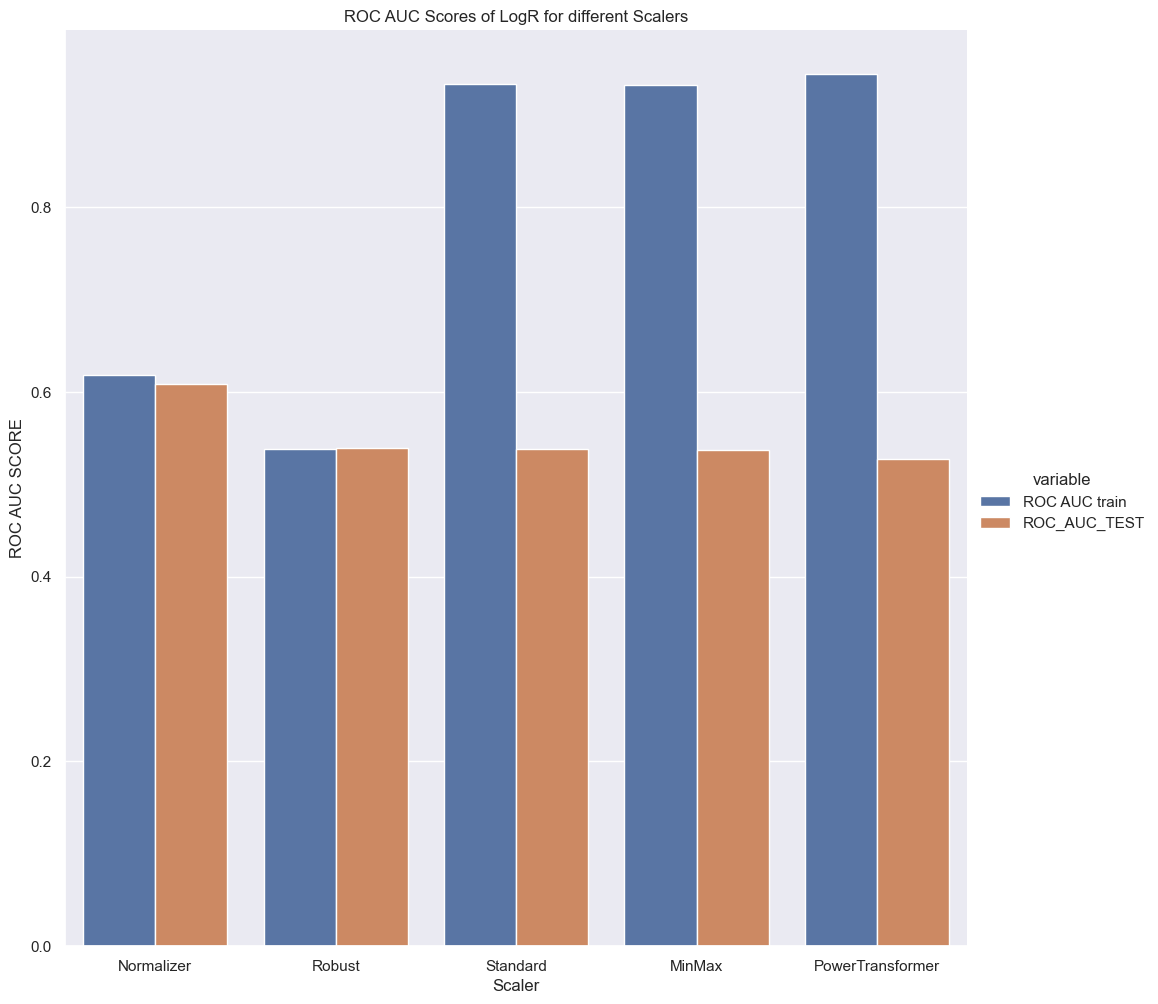

In [96]:
#Converting our scores array into a Dataframe    
scores = pd.DataFrame(scores)

#Selecting average ROC AUC Score and accuracy by model
scores = scores.groupby("Scaler").mean().reset_index().sort_values(by="ROC AUC test", ascending=False)

scores_melt = pd.melt(scores, id_vars='Scaler')
sns.set(rc={'figure.figsize':(20,15)})
sns.catplot(x='Scaler', y='value', hue='variable', data=scores_melt, kind='bar', height = 10)
plt.title("ROC AUC Scores of LogR for different Scalers")
plt.xlabel("Scaler")
plt.ylabel("ROC AUC SCORE")
plt.show()

In [99]:
#Import tqdm to visualize algorithm run
from tqdm.notebook import tqdm,tnrange
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer, PowerTransformer

#Creating K-fold validation leaves
k = 3
kf = KFold(n_splits=3, shuffle=True)

scores_dt = []

#Defining the Scalers
scalers = [[StandardScaler(), "Standard"], [RobustScaler(), "Robust"], [MinMaxScaler(), "MinMax"],
           [Normalizer(), "Normalizer"], [PowerTransformer(), "PowerTransformer"]]

for train_index, test_index in tqdm(kf.split(df), desc='K', total=k):
    train = df.loc[df.index.isin(train_index)]
    test  = df.loc[df.index.isin(test_index)]
    y_train_cv = train["TARGET"]
    y_test_cv = test["TARGET"]
    X_train_cv = train.drop(columns={"TARGET"})
    X_test_cv = test.drop(columns={"TARGET"})
    #Performing data imputation
    data_imputation(X_train_cv)
    data_imputation(X_test_cv)

    #Encoding variables
    X_test_cv = encode_cat_vars(X_test_cv, X_train_cv, y_train_cv, max_categ=5, full_encode=False)
    X_train_cv = encode_cat_vars(X_train_cv, X_train_cv, y_train_cv, max_categ=5, full_encode=False)
    X_train_cv, X_test_cv = X_train_cv.align(X_test_cv, join='left', axis=1)

    #Oversampling
    X_train_cv, y_train_cv, X_train_init, y_train_init = over_sample_train(X_train_cv, y_train_cv)

    #Feature selection
    X_train_cv, X_test_cv = perform_variance_selection(X_train_cv, X_test_cv)
    
    for scaler in scalers:
        pipe_lr = Pipeline([('scaler', scaler[0]), 
                    ('log_r', DecisionTreeClassifier())])
        
        pipe_lr.fit(X_train_cv, y_train_cv)
        train_predictions = pipe_lr.predict(X_train_cv)
        test_predictions = pipe_lr.predict(X_test_cv)
        roc_train = roc_auc_score(y_train_cv, train_predictions) 
        roc_test = roc_auc_score(y_test_cv, test_predictions)
        print(roc_train, roc_test)
        scores_dt.append({'Scaler': scaler[1], 'ROC AUC train': roc_train, 'ROC AUC test': roc_test })

K:   0%|          | 0/3 [00:00<?, ?it/s]

1.0 0.539715092469804
1.0 0.5384978156051797
1.0 0.5362095901683857
1.0 0.5266339073558628
1.0 0.5392030317247762
1.0 0.5296240253693333
1.0 0.5318397538250785
1.0 0.5308266527206404
1.0 0.5317232421619243
1.0 0.5314914123066875
1.0 0.5384507518011589
1.0 0.5390317144332292
1.0 0.5389691545797378
1.0 0.5245938298441947
1.0 0.5425404119684134


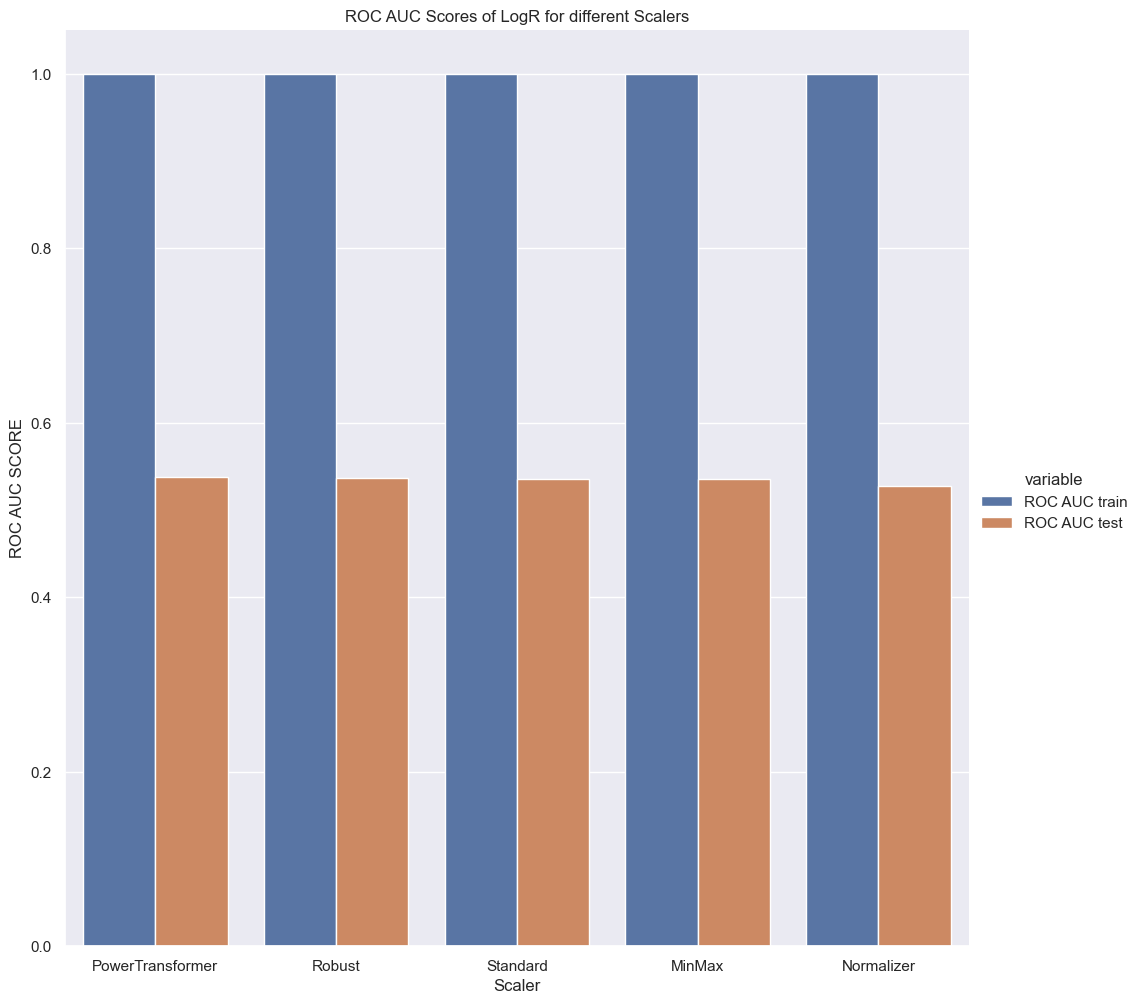

In [100]:
#Converting our scores array into a Dataframe    
scores_dt = pd.DataFrame(scores_dt)

#Selecting average ROC AUC Score and accuracy by model
scores_dt = scores_dt.groupby("Scaler").mean().reset_index().sort_values(by="ROC AUC test", ascending=False)

scores_melt = pd.melt(scores_dt, id_vars='Scaler')
sns.set(rc={'figure.figsize':(20,15)})
sns.catplot(x='Scaler', y='value', hue='variable', data=scores_melt, kind='bar', height = 10)
plt.title("ROC AUC Scores of LogR for different Scalers")
plt.xlabel("Scaler")
plt.ylabel("ROC AUC SCORE")
plt.show()



### 7.2 Model Hyperparameter tuning

Now that we've selected ideal scalers for both models, we will tune hyperparameters to increase our performance indicator ==> ROC AUC. We will use the sklearn **Grid Search Cross Valided** package to perform this hyperparameter tuning.

In [ ]:
from sklearn.model_selection import GridSearchCV
import warnings
#Import tqdm to visualize algorithm run
from tqdm.notebook import tqdm,tnrange
from sklearn.model_selection import KFold
from sklearn.model_selection import PredefinedSplit
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer, PowerTransformer

X_train_val = pd.concat([X_train, X_val])
# Create a list where train data indices are -1 and validation data indices are 0
split_index = [-1 if x in X_train.index else 0 for x in X.index]

# Use the list to create PredefinedSplit
pds = PredefinedSplit(test_fold = split_index)

warnings.filterwarnings('ignore')
parameters = {
    'log_r__penalty' : ['l1','l2'], 
    'log_r__C'       : np.logspace(-3,3,7),
    'log_r__solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
}
pipe_lr = Pipeline([('scaler', StandardScaler()), 
                    ('log_r', LogisticRegression(max_iter = 2000))])
clf = GridSearchCV(pipe_lr, 
                   param_grid = parameters,
                   scoring = 'roc_auc', 
                   cv = pds,
                  verbose=10)
clf.fit(X_train,y_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("ROC AUC :",logreg_cv.best_score_)

Fitting 1 folds for each of 42 candidates, totalling 42 fits
[CV 1/1; 1/42] START log_r__C=0.001, log_r__penalty=l1, log_r__solver=newton-cg.
[CV 1/1; 1/42] END log_r__C=0.001, log_r__penalty=l1, log_r__solver=newton-cg;, score=nan total time=   0.9s
[CV 1/1; 2/42] START log_r__C=0.001, log_r__penalty=l1, log_r__solver=lbfgs.....
[CV 1/1; 2/42] END log_r__C=0.001, log_r__penalty=l1, log_r__solver=lbfgs;, score=nan total time=   1.0s
[CV 1/1; 3/42] START log_r__C=0.001, log_r__penalty=l1, log_r__solver=liblinear.
[CV 1/1; 3/42] END log_r__C=0.001, log_r__penalty=l1, log_r__solver=liblinear;, score=nan total time=   8.3s
[CV 1/1; 4/42] START log_r__C=0.001, log_r__penalty=l2, log_r__solver=newton-cg.
[CV 1/1; 4/42] END log_r__C=0.001, log_r__penalty=l2, log_r__solver=newton-cg;, score=nan total time= 1.3min
[CV 1/1; 5/42] START log_r__C=0.001, log_r__penalty=l2, log_r__solver=lbfgs.....
[CV 1/1; 5/42] END log_r__C=0.001, log_r__penalty=l2, log_r__solver=lbfgs;, score=nan total time=   3.

### 7.2 Categorical variable encoding

We had a high number of categorical variables, their encoding can significantly change our results.

In [ ]:
#Import tqdm to visualize algorithm run
from tqdm.notebook import tqdm,tnrange

#K fold cross validation
from sklearn.model_selection import KFold
#Creating K-fold validation leaves
kf = KFold(n_splits=5, shuffle=True)

#Initializing our scores array
scores = []
df = df.copy()
#Defining our encoders:
encoders = ['mixed', 'ordinal', 'woe', 'ohe']

for enc in tqdm(encoders, desc='encoder'):
    for train_index, test_index in tqdm(kf.split(df),desc='K',total=5):
        train = df.loc[df.index.isin(train_index)]
        test  = df.loc[df.index.isin(test_index)]
        
        y_train = train["TARGET"]
        y_test = test["TARGET"]
        X_train = train.drop(columns={"TARGET"})
        X_test = test.drop(columns={"TARGET"})
        #Performing data imputation
        numeric_data_imputation(X_train)
        numeric_data_imputation(X_test)
        
        #Encoding variables
        X_test = encode_cat_vars(X_test, X_train, y_train, max_categ=10, full_encode=enc)
        X_train = encode_cat_vars(X_train, X_train, y_train, max_categ=10, full_encode=enc)
        X_train, X_test = X_train.align(X_test, join='left', axis=1)

        #Oversampling
        X_train, y_train, X_train_init, y_train_init = over_sample_train(X_train, y_train)

        #Feature selection
        X_train, X_test = perform_variance_selection(X_train, X_test)
        
        roc_train, roc_test = logr_classifier(X_train, X_test)
        print(roc_train, roc_test)
        
        scores.append({'Encoder': enc, 'ROC AUC train': roc_train, 'ROC_AUC_TEST': roc_test })

In [ ]:
#Converting our scores array into a Dataframe    
scores = pd.DataFrame(scores)

#Selecting average ROC AUC Score and accuracy by model
scores = scores.groupby("Encoder").mean().reset_index()

sns.barplot(data = scores, x="Encoder", y="ROC_AUC_TEST")
plt.show()

**The Weight of Evidence (WoE)** encoder is the **most performant** for our Logistic Regression Algorithm.

Now let's try to tune our Feature Selection process.

### 7.2 Feature Selection

In [ ]:
#Import tqdm to visualize algorithm run
from tqdm.notebook import tqdm,tnrange

#K fold cross validation
from sklearn.model_selection import KFold

kf = KFold(n_splits=4, shuffle=True)

#Initializing our scores array
scores = []
df = df.copy()
#Defining our encoders:
selectors = ['mixed', 'variance', 'correlation', 'kbest']

for sel in tqdm(selectors, desc='Selector'):
    for train_index, test_index in tqdm(kf.split(df),desc='K',total=3):
        train = df.loc[df.index.isin(train_index)]
        test  = df.loc[df.index.isin(test_index)]
        
        y_train = train["TARGET"]
        y_test = test["TARGET"]
        X_train = train.drop(columns={"TARGET"})
        X_test = test.drop(columns={"TARGET"})
        #Performing data imputation
        numeric_data_imputation(X_train)
        numeric_data_imputation(X_test)
        
        #Encoding variables
        X_test = encode_cat_vars(X_test, X_train, y_train, max_categ=10, full_encode='woe')
        X_train = encode_cat_vars(X_train, X_train, y_train, max_categ=10, full_encode='woe')
        X_train, X_test = X_train.align(X_test, join='left', axis=1)

        #Oversampling
        X_train, y_train, X_train_init, y_train_init = over_sample_train(X_train, y_train)

        #Feature selection
        X_train, X_test = select_features(X_train, X_test, y_train, unique_select=sel)
        
        roc_train, roc_test = logr_classifier(X_train, X_test)
        print(roc_train, roc_test)
        
        scores.append({'Selector': sel, 'ROC_AUC_train': roc_train, 'ROC_AUC_TEST': roc_test })

In [ ]:
#Converting our scores array into a Dataframe    
scores = pd.DataFrame(scores)

#Selecting average ROC AUC Score and accuracy by selector
scores = scores.groupby("Selector").mean().reset_index().sort_values(by="ROC_AUC_TEST", ascending=False)

sns.barplot(data = scores, x="Selector", y="ROC_AUC_TEST")
plt.show()

In [ ]:
#Import tqdm to visualize algorithm run
from tqdm.notebook import tqdm,tnrange

#K fold cross validation
from sklearn.model_selection import KFold

kf = KFold(n_splits=2, shuffle=True)

#Initializing our scores array
scores = []
df = df.copy()
#Defining our encoders:
selectors = [['correlation', np.arange(0.7,1,0.01)],['kbest', np.arange(1,51,1)]]

for sel in tqdm(selectors, desc='Selector'):
    for param in tqdm(sel[1], desc='Hyperparameter'):
        for train_index, test_index in tqdm(kf.split(df),desc='K',total=2):
            train = df.loc[df.index.isin(train_index)]
            test  = df.loc[df.index.isin(test_index)]

            y_train = train["TARGET"]
            y_test = test["TARGET"]
            X_train = train.drop(columns={"TARGET"})
            X_test = test.drop(columns={"TARGET"})
            #Performing data imputation
            numeric_data_imputation(X_train)
            numeric_data_imputation(X_test)

            #Encoding variables
            X_test = encode_cat_vars(X_test, X_train, y_train, max_categ=10, full_encode='woe')
            X_train = encode_cat_vars(X_train, X_train, y_train, max_categ=10, full_encode='woe')
            X_train, X_test = X_train.align(X_test, join='left', axis=1)

            #Oversampling
            X_train, y_train, X_train_init, y_train_init = over_sample_train(X_train, y_train)

            #Feature selection
            X_train, X_test = select_features(X_train, X_test, y_train, unique_select=sel[0], k=param, corr_threshold=param)

            roc_train, roc_test = logr_classifier(X_train, X_test)
            print(roc_train, roc_test)

            scores.append({'Selector': sel[0], 'Hyperparameter': param,
                           'ROC AUC train': roc_train, 'ROC AUC TEST': roc_test })

In [ ]:
#Converting our scores array into a Dataframe    
scores = pd.DataFrame(scores)

#Selecting average ROC AUC Score and accuracy by selector
scores = scores.groupby(["Selector","Hyperparameter"]).mean().reset_index().sort_values(by="ROC AUC TEST", ascending=False)

In [ ]:
for sel in scores.Selector.unique():
    subset = scores[scores.Selector == sel]
    sns.lineplot(data=subset, x='Hyperparameter', y="ROC AUC TEST")
    plt.show()

### 6.2 Support Vector Classification (Linear)

In [ ]:
from sklearn.svm import LinearSVC

pipe_lsvc = Pipeline([('scaler', StandardScaler()), ('svc_l', LinearSVC())])

pipe_lsvc.fit(X_train, y_train)

train_predictions = pipe_lsvc.predict(X_train)
test_predictions = pipe_lsvc.predict(X_test)

print("Logistic Regression results")
print("TRAIN:")
print(classification_report(y_train, train_predictions))
print("----------------------")
print("TEST:")
print(classification_report(y_test, test_predictions))

### 6.3 KNeighbors Classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

pipe_knc = Pipeline([('scaler', StandardScaler()), ('knc', KNeighborsClassifier())])

pipe_knc.fit(X_train, y_train)

train_predictions = pipe_knc.predict(X_train)
test_predictions = pipe_knc.predict(X_test)

print("Logistic Regression results")
print("TRAIN:")
print(classification_report(y_train, train_predictions))
print("----------------------")
print("TEST:")
print(classification_report(y_test, test_predictions))